# Пакет лучевого трассирования SeisLab
## Руководство для быстрого старта

Пакет SeisLab предназначен для расчёта синтетических волновых полей в приближении главного члена лучевого ряда. Алгоритмы, реализованные в пакете, основаны двух допущениях:
1. Рассматриваются только однородно-слоистые модели сред без выклинивания;
2. При построении лучей решается двухточечная задача.

Кроме них есть и другие, более локальные предположения. Они будут проявляться по мере продвижения по основным модулям SeisLab.

В этом руководстве будет приведена инструкция для как можно более быстрого начала работы с программой. Детальное описание работы всего-всего-всего здесь не даётся.

## Основные модули

In [1]:
# Импортируем библиотеки. Я не понимаю, почему, но "сковзной" импорт не работает.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Импортируем главные компоненты для лучевого моделирования
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2
import src

from src import tprt


Выше были импортированы наиболее значимые классы, фигурирующие в проекте. Некоторые из них являются дочерними к более общим сущностям. Так, классы FlatHorizon и GridHorizon наследуют методы класса Horizon. 

Названия классов более или менее соответсвуют физическим сущностям, которые эти классы описывают:
- **FlatHorizon** - класс, описывающий плоские геологические границы;
- **GridHorizon** - класс, описывающий криволинейные границы, заданные на сетке;
- **ISOVelocity** - класс, созданные для взаимодействия с изотропными скоростными моделями. По сути, объекты этого класса являются парами [Vp, Vs] с возможностью удобного (с точки зрения сейсмика) вызова любого из элементов;
- **Layer** - класс, описывающий геологические слои;
- **Velocity_model** - класс, описывающий скоростные (и плотностные, на самом деле) модели среды;
- **DilatCenter** - класс, описывающий источники типа центра расширения;
- **RotatCenter** - класс, описывающий источники типа центра вращения;
- **Receiver** - класс, описывающий приёмники;
- **Ray** - класс, описывающий лучи.

Ниже под "моделями", "слоями" или "горизонтами" будут иметься ввиду объекты соответствующих классов.
<hr>

## Создание модели*
### * На примере трёхслойной модели с одной плоской и одной криволинейной границами со следующими свойствами слоёв:
* Vp_1 = 2000 м/с, Vs_1 = 1000 м/с, Dens_1 = 2300 кг/м**3
* Vp_2 = 2500 м/с, Vs_2 = 1250 м/с, Dens_2 = 2400 кг/м**3
* Vp_3 = 3000 м/с, Vs_3 = 1500 м/с, Dens_3 = 2500 кг/м**3

В конструктор класса моделей передаются массивы скоростей, плотностей и горизонтов, из которых затем автоматически собирается слоистая модель. **Важно отметить, что свободная поверхность не моделируется, т.е. модель простирается на бесконечность "вверх" и "вниз".** Скорости и плотности создаются тривиально:

In [2]:
# Скорости волн в слое задаются объектами класса ISOVelocity, в конструктор которого подаются пары Vp, Vs.
# Желательно задавать скорости в м/с.
vel_1 = tprt.ISOVelocity(vp=2000.0, vs=1000.0)
vel_2 = tprt.ISOVelocity(vp=2500.0, vs=1250.0)
vel_3 = tprt.ISOVelocity(vp=3000.0, vs=1500.0)

In [3]:
# Плотности задаются напрямую - просто числами. Желательно задавать плостности в кг/м**3:
dens_1 = 2300.0
dens_2 = 2400.0
dens_3 = 2500.0

Создание горизонтов - более сложный процесс. Во-первых, есть два класса для горизонтов, и для создания каждого из них требуются разные данные. Во-вторых, **пользователь гарантирует, что задаваемые им горизонты не пересекаются в моделируемом участке среды и несёт личную ответственность за достоверность предоставленных сведений**.

В нашей трёхслойной всего две границы. 

1) Пусть одна из них (верхняя) будет <i>плоским горизонтом</i>. Плоские горизонты задаются через глубину точки, лежащей на таком горизонте, её координаты на плоскости, угол и азимут падения горизонта, а также через дополнительный параметр - область задания горизонта:

``` python 
hor_1 = tprt.FlatHorizon(depth=200,...)
```

2) Вторая граница будет криволинейной. Криволинейные границы в SeisLab задаются дискретно, на регулярной прямоугольной сетке. Для создания границы необходимы:
    - Массив x_set = [x_0, x_1, ..., x_M]
    - Массив y_set = [y_0, y_1, ..., y_N]
    - Массив z_set = [[z_00, z_01, ..., z_0N], [z_10, z_11, ..., z_1N], ... , [z_M0, z_M1, ..., zMN]]
Пусть наша граница будет задана на сетке 
    - x_set = [- 1000, - 998, ..., 998, 1000], 
    - y_set = [- 1000, - 998, ..., 998, 1000]. 
    - В качестве функции границы возьмём медленно осциллирующий синус: z = 700 + 100 sin(2 pi * (x / 4000 + y / 4000)).

``` python 
hor_2 = GridHorizon(x_set=x_set, y_set=y_set,z_set=z_set,bool_parab=False)
```

Стоит сказать несколько слов про последний аргумент в конструкторе. <i>Регион</i> является прямоугольной областью на плоскости, задаваемой в виде [[x_min, y_min], [x_max, y_max]], т.е. в виде массива, в котором явно задаются координаты противолежащих углов прямоугольника. **На данный момент это поле используется только при определении ганиц отрисовки горизонтов**.

Для создания криволинейной границы необходимо в конструктор подать все три массива - x_set, y_set и z_set. Опциональным агументом, повышающим устойчивость интерполяции к выбивающимся точкам, но понижающим общую точность интерполяции, подаётся булевская величина - True или False. Для целей этого руководства мы приравняем её False (т.е. этот триггер отключен):

### ВНИМАНИЕ

**Внутри конструктора вычисляются полиномиальные коэффициенты бикубической интерполяции**, что в имеющейся на данный момент имплементации является очень долгой процедурой (более пяти минут на компьютере с частотой процессора 1.8 ГГц, а сетка была не самой большой (процессор тоже далеко не мощный, но мысль, я надеюсь, понятна)). Поэтому есть возможность подать ещё одним аргументом уже готовый массив полиномиальных коэффициентов, если он был насчитан заранее. Это удобно, если одну и ту же границу нуно будет использовать во многих сериях вычислений.

Надо отметить, что <i>регион</i> в случае криволинейных границ явно не задаётся. Его границы определяются по входным массивам x_set и y_set.
<hr>
В конструктор модели последовательно передаются:
* массив скоростей;
* массив плотностей;
* массив имен слоев (если хочется их называть);
* массив границ

In [4]:
hor_1 = tprt.FlatHorizon(
    depth=200,
    anchor=np.array([0, 0]),
    dip = 10, # угола падения В ГРАДУСАХ
    azimuth=0, # азимут падения в ГРАДУСАХ
    region = np.array([[- 1000, - 1000], [1000, 1000]])
)

In [5]:
x_set = np.linspace(- 1000, 1000, 1001)
y_set = np.linspace(- 1000, 1000, 1001)

yy_set, xx_set = np.meshgrid(y_set, x_set)

z_set = 700 + 100 * np.sin(2 * np.pi * (xx_set + yy_set) / 4000)

In [6]:
hor_2 = tprt.GridHorizon(
    x_set=x_set,
    y_set=y_set,
    z_set=z_set,
    bool_parab=False
)

In [7]:
model = tprt.VelocityModel(np.array([vel_1, vel_2, vel_3]),
                       np.array([dens_1, dens_2, dens_3]),
                       np.array([1, 2, 3]),                      
                       [hor_1, hor_2])

<hr>

## Взаимодействие с моделью и её элементами

Модель состоит из слоёв, каждый из которых характеризуется:
- номером, 
- скоростями распространения волн, 
- плотностью,
- двумя перекрывающими горизонтами (выше было отмечено, что первый номер в модели простирается на бесконечность "вверх", что реализуется в виде плоского горизонта на бесконечности).

In [8]:
layers = model.layers

print("Имя первого горизонта:", layers[0].name)
print("Скорость P-волн в первом слое равна", layers[0].get_velocity(0)["vp"], "м/с")
print("Скорость S-волн в первом слое равна", layers[0].get_velocity(0)["vs"], "м/с")
print("Плотность пород в первом слое равна", layers[0].get_density(), "кг/м**3")

Имя первого горизонта: 1
Скорость P-волн в первом слое равна 2000.0 м/с
Скорость S-волн в первом слое равна 1000.0 м/с
Плотность пород в первом слое равна 2300.0 кг/м**3


В предыдущей ячейке продемонстрирован вызов скоростей волн в слое. Метод layer.get_velocity(<i>something</i>) принимает в качестве аргумента любое число (на самом деле, <i>пока что</i> можно вместо числа подать список или строку). Это число сейчас ни на что не влияет, но в дальнейшем планируется его использование для нахождения скорости в заданном направлении для анизотропной среды.

Приписка ["vp"] или ["vs"] после вызова метода необходима, чтобы получить конкретную скорость. Без неё метод возвращает словарь из двух элементов:

In [9]:
layers[0].get_velocity(0)

{'vp': 2000.0, 'vs': 1000.0}

Вызов плостности не нуждается в дополнительных комментариях.
<hr>
Для вызова горизонтов, ограничивающих данный слой, используются отдельные методы класса Layer. Определённые выше hor_1 и hor_2 ограничивают сверху и снизу второй слой. Вызовем эти горизонты через него:

In [10]:
top_hor = layers[1].top
bottom_hor = layers[1].bottom

**Все горизонты в SeisLab должны являться дважды гладкими функциями вида z = z(x, y)**. В частности, бикубическая интерполяция строится именно из условия непрерывности второй производной.

У таких горизонтов в любой их точке определены:
* Глубина;
* Градиент;
* Нормаль;
* Вторые производные (=> кривизны).

Первые три величины могут быть получены следуюшим образом:

In [11]:
print("Глубина верхнего горизонта в точке с координатами x = 0, y - 0:", top_hor.get_depth(np.array([0, 0])), "м")
print("Градиент функции верхнего горизонта в точке с координатами x = 0, y - 0:",
      top_hor.get_gradient(np.array([0, 0])))
print("Нормаль к верхнему горизонту в точке с координатами x = 0, y - 0:",
      top_hor.get_normal(np.array([0, 0])))

Глубина верхнего горизонта в точке с координатами x = 0, y - 0: 200.0 м
Градиент функции верхнего горизонта в точке с координатами x = 0, y - 0: [ 0.17632698  0.        ]
Нормаль к верхнему горизонту в точке с координатами x = 0, y - 0: [-0.17364818 -0.          0.98480775]


**Нормаль к границе строится таким образом, что её компонента по z положительна**.

Вторые производные примечательны тем, что в теории лучевого метода они должны вычисляться, как правило, не в глобальной системе координат. На поверхность в некоторой точке падает луч, характеризующийся своим <i>направлением</i>. В точке падения строится локальная система координат, базисные векторы которой связаны с этим направлением и с нормалью к границе. Для вычисления лучевой амплитуды необходимо знать вторые производные функции поверхности в новой системе координат и матрицу перехода к этой системе.

Поэтому метод класса Horizon, находящий вторые производные и матрицу перехода, называется get_local_properties, и ему на вход передаются x- и y-координаты точки падения, а также вектор направления падающего луча:

In [12]:
# пусть вертикальный луч падает на нижний горизонт в точке с координатами x = 0, y = 0:
inc_vec = np.array([0, 0, 1])

z_11, z_12, z_22, tr_matr = bottom_hor.get_local_properties(np.array([0, 0]), inc_vec)

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
print("Матрица вторых производных поверхности в локальной системе координат:\n",
      np.array([[z_11, z_12], [z_12, z_22]]))

In [ ]:
print("Матрица перехода в локальную систему координат:\n", tr_matr)
print("Нормаль к нижней границе в точке падения", bottom_hor.get_normal(np.array([0, 0])))

Заметьте, что третий столбец в матрице перехода в данном случае совпадает с нормалью к границе. Однако, в общем случае совпадения нет: локальная система координат строится с тем, чтобы ось z' в ней была направлена в ту же среду, куда и падающий луч, поэтому третий орт может как совпадать с нормалью, так и быть протвонаправлен ей.
<hr>

## Создание системы наблюдения (источники, приемники, лучи)
### * На примере волны, отражённой от второй границы в заданной модели

#### 1) Для начала нужно создать нужное количество источников и приемников
#### 2) Для инициализации системы наблюдения нам понадобятся списки источников и приемников, и скоростная модель

В SeisLab на данный момент реализовано два типа точечных источников сейсмических волн - центр расширения (идеальный источник P-волн) и центр вращения (идеальный источник S-волн). Оба источника излучают в среду импульс Рикера с некоторой главной частотой.

Для создания источника необходимы:
* Главная частота импульса Рикера;
* Модель, в которую источник помещается;
* Координаты источника
* (только для центра вращения) ось вращения.

Создадим источник типа центра расширения, расположенный на поверхности z = 0 в точке с координатами x = 0, y = 0 (т.е. в первом слое). В качестве главной частоты возьмём 25 Гц:

In [13]:
source_freq = 25.0
source_location = np.array([0, 0, 0], dtype=float)

Для дальнейшего создания системы наблюдения мы будем использовать список источников и приемников, поэтому создадим список из одного источника

In [14]:
sources = tprt.DilatCenter(model, source_freq, source_location)

Приёмники характеризуются местоположением и ориентацией. Последнюю можно не задавать явно - по умолчанию оси чувствительности приёмника будут совпадать с осями глобальной системы координат.

Зададим 3 сети наблюдения:
1. профиль в координатах $x \in [-800,800]\, м$ с шагом $50 \, м$ и $z=0$;
2. поверхностную сеть наблюдения в квадрате $x,y \in [-800,800]\, м$ с шагом $100 \, м$ по обеим осям и $z=0$;
3. скважинную в точке $(x,y) = (500,500)$ и $z \in [125, 1525] \, м$ с шагом $50 \, м$.

In [15]:
rec_loc_x = np.arange(-800, 800, 100)
rec_loc_z = np.arange(125, 1525, 50)
shape = rec_loc_x.shape + rec_loc_x.shape

receivers_profile = np.empty(rec_loc_x.shape, dtype=tprt.Receiver)
receivers_surface = np.empty(shape, dtype=tprt.Receiver)
receivers_borehole = np.empty(rec_loc_z.shape, dtype=tprt.Receiver)

orientation = np.array([
    [1, 0, 0],  # axis x
    [0, -1, 0], # axis y
    [0, 0, -1]  # axis z
])

for i, _x in enumerate(rec_loc_x):
    receivers_profile[i] = tprt.Receiver([_x, 0.0, 0.0], orientation=orientation)
    for j, _y in enumerate(rec_loc_x):
        receivers_surface[i, j] = tprt.Receiver([_x, _y, 0], orientation=orientation)
        
for i, _z in enumerate(rec_loc_z):
    receivers_borehole[i] = tprt.Receiver([500.0, 500.0, _z], orientation=orientation)

**Ориентация приёмников была выставлена так, чтобы их вертикальная ось чувствительности "смотрела" вверх. По умолчанию она направлена вниз, сонаправлено с осью глубин**.

Для построения лучей необходимо задаться так называемым <i>лучевым кодом</i>. Лучевой код - это массив элементов вида:

[<"вверх" или "вниз">, <номер слоя>, <тип волны>]

* "вверх" или "вниз" - число, 1 или - 1. Задаёт направление движения по модели;
* номер слоя - номер слоя, в котором распространется волна (нумерация слоёв - с нуля);
* тип волны - число, указывающее на тип волны. 0 - P-волна, 1 - S-волна;

Такой подход базируется на форме лучей в доступных для SeisLab моделях среды. В однородно-слоистых средах лучи являются ломаными кривыми, и лучевой код, по сути, задаёт последовательность сегментов этой ломаной.

Пример P-волны, отражённой от второй границы:

In [16]:
ray_code = [[1, 0, 0],
           [1, 1, 0],
           [- 1, 1, 0],
           [- 1, 0, 0]]

**В SeisLab есть автоматическая проверка лучевого кода на корректность для данной модели. Однако кастомное задание кода луча является специфической процедурой, которая может понадобится при рассмотрении каких-нибудь обменных или головных волн (только для плоских горизонтов). Здесь же, для создания лучей мы будем использовать специальный класс Survey который отвечает за автоматический сбор системы наблюдения с её составными частями - лучами. Нам нужно будет только указать, что мы хотим. Пока поддерживается 2 типа волн: отраженные (актуально для поверхностной системы наблюдения) и прямые (для скважинной) монотипные волны.**.

Для инициализации системы наблюдения (Survey) в конструктор необходимо подать:
* Список источников;
* Список приёмников;
* Скоростная модель.

Соответственно мы создаем 2 системы наблюдения: скважинную (borehole) и поверхностную (surface). Источник оставим одним и тем же.

In [17]:
survey_profile = tprt.Survey(sources, receivers_profile, model)
survey_surface = tprt.Survey(sources, receivers_surface, model)
survey_borehole = tprt.Survey(sources, receivers_borehole, model)

После, инициализации Survey, лучи еще не построены. При построении начальных лучей (которые пока не являются реальными) нам необходимо указать:
* тип рассматриваемой волны - vtype ('vp' или 'vs')
* если это отраженная волна то мы должны указать отражающий горизонт - reflect_horizon*
* если это прямая волна - forward = True

*reflect horizon - номер границы относительно положения источника при увеличении глубины.

Для поверхностной системы наблюдения создадим лучи отраженные от второй границы, для скважинные используем прямые волны. На самом деле, для скважинной системы наблюдения мы тоже можем рассматривать отраженные волны, однако здесь необходимо учесть, что ВСЕ приемники в скважине находятся выше отражающего горизонта, иначе проверка кода луча даст ошибку. 

In [18]:
survey_profile.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)
survey_surface.initialize_rays(reflect_horizon=2, vtype='vp', forward=False)
survey_borehole.initialize_rays(reflect_horizon=2, vtype='vp', forward=True)

**Созданные только что лучи не являются лучами в строгом понимании этого слова. Их траектория случайна (узлы ломаной находятся на правильных границах, но траектория ломаной не является оптимальной с точки зрения времён пробега), а амплитуды выставлены единичными**. Необходимо оптимизировать полученные лучи и посчитать правильную амплитуду вдоль них. Для этого используется метод Survey.calculate(). Этот метод имеет два аргумента:
* method - метод оптимизации, влияет на скорость сходимости. 
Строго говоря нормальным образом поддерживаются только два: 'Nelder-Mead' (симплексный метод), 'BFGS' (градиентный). По умолчанию стоит BFGS, так как он использует производную вдоль луча, что в разы быстрее чем Nelder-Mead
* survey2D - (boolean). Если True то лучи строятся в вертикальной плоскости Источник-Приемник, если False - то лучи 3-хмерные какими и должны быть. 2-мерная оптмизация работает быстрее чем 3-хмерная, и это становится актуальным если среда близка к горизонтально слоистой.

In [59]:
%%time
# survey_profile.calculate(method='bfgs', survey2D=True)
survey_surface.calculate(method='bfgs', survey2D=True)
survey_borehole.calculate(method='bfgs', survey2D=True)

LinAlgError: Singular matrix

In [56]:
from src import plot_maps
from src import seislet
from src import plot_seismic

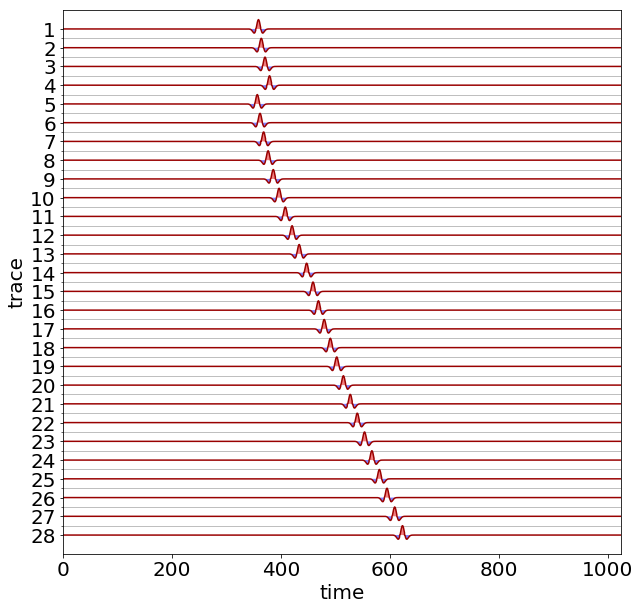

In [57]:
traces = seislet.seismic_signal(tau=survey_borehole.traveltimes.T, ns=1024)
plot_seismic.plot_traces(traces, fill_positive=True, fill_negative='b', invert_y_axis=True)

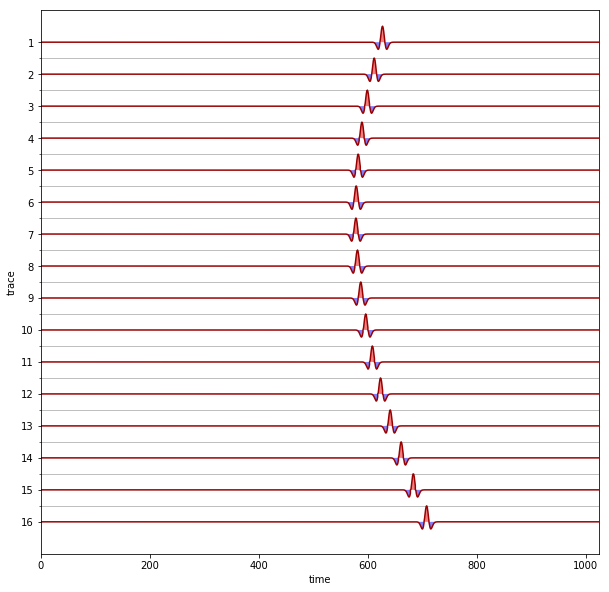

In [54]:
traces = seislet.seismic_signal(tau=survey_profile.traveltimes.T, ns=1024)
plot_seismic.plot_traces(traces, fill_positive=True, fill_negative='b', invert_y_axis=True, font_size=10)

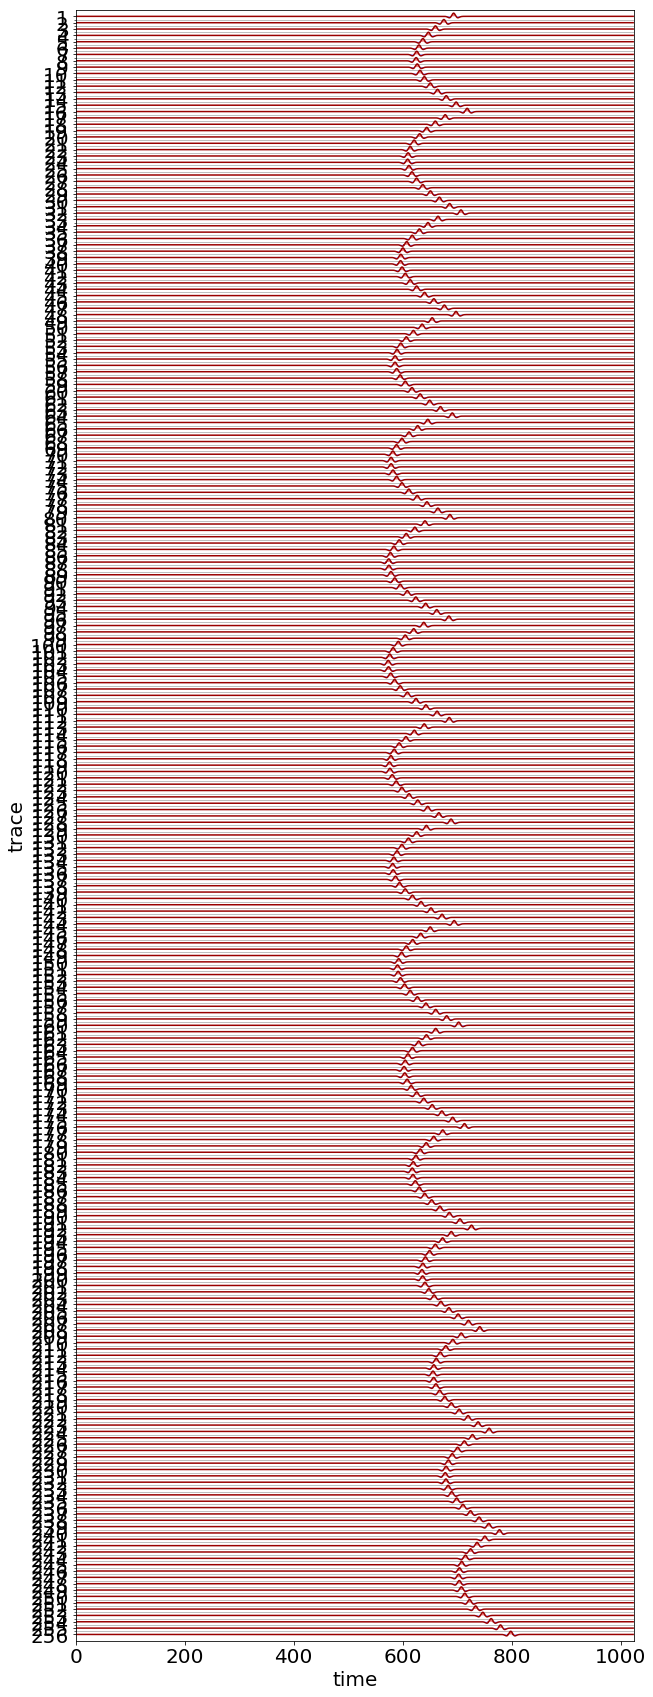

In [53]:
traces = seislet.seismic_signal(tau=survey_surface.traveltimes.reshape(-1,1), ns=1024)
plot_seismic.plot_traces(traces, fill_positive=True, fill_negative='b', invert_y_axis=True, fig_height=30)

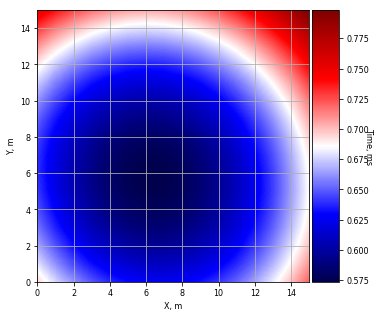

In [35]:
traveltimes = survey_surface.traveltimes
plot_maps.plot_map(traveltimes, interpolation='bilinear', add_colorbar=True, colorbar_label='Time, ms', font_size=8, fig_width=10)

Для расчёта времени пробега волны и определения амплитуды на данной трассе в некоторый момент времени используется еще один метод Survey.get_traveltimes(), который возвращает двумерный массив размера (число источников, число приемников)

In [21]:
traveltime_curve = survey_surface.traveltimes # массив для годографа

record_time = np.linspace(0, 2, 2001) # дискретизованное время записи

seismogram_x = np.zeros((len(traveltime_curve.ravel()), record_time.shape[0]), dtype=complex) # массив для сейсмограмм (x-компонента)
seismogram_y = seismogram_x.copy() # массив для сейсмограмм (y-компонента)
seismogram_z = seismogram_x.copy() # массив для сейсмограмм (z-компонента)

In [85]:
%%time
for i, ray in enumerate(survey_borehole.rays[0]):   
    for j in range(record_time.shape[0]): 
        seismogram_x[i, j], seismogram_y[i, j], seismogram_z[i, j] = ray.get_recorded_amplitude(record_time[j])
        # записываем амплитуду в приёмнике

Wall time: 5.78 s


## Графическое представление данных

**В SeisLab нет функции / метода вроде plot_model**. Для отрисовки модели и лучей необходимо вызвать методы классов Horizon и Ray, по очереди для каждого объектна в отдельности.

In [21]:
%matplotlib notebook

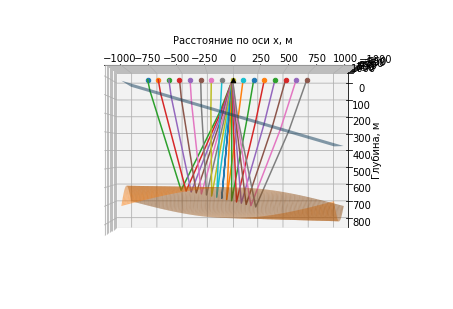

In [22]:
fig1 = plt.figure()
ax = Axes3D(fig1)
ax.invert_zaxis()

ax.view_init(0, - 90)

model.plot(ax=ax)

survey_profile.plot(ax=ax)

# Create cubic bounding box to simulate equal aspect ratio
# max_range = np.array([horizons[-1].X.max()-horizons[-1].X.min(), horizons[-1].Y.max()-horizons[-1].Y.min(), horizons[-1].Z.max()-horizons[-1].Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(horizons[-1].X.max()+horizons[-1].X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(horizons[-1].Y.max()+horizons[-1].Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(horizons[-1].Z.max()+horizons[-1].Z.min())
# # Comment or uncomment following both lines to test the fake bounding box:
# for xb, yb, zb in zip(Xb, Yb, Zb):
#     ax.plot([xb], [yb], [zb], 'w')

ax.set_xlabel("Расстояние по оси x, м")
# ax.set_ylabel("Расстояние по оси y, м",)
ax.set_zlabel("Глубина, м")

plt.show()

Можно также нарисовать годографы

In [27]:
T = survey_surface.traveltimes
X, Y = np.meshgrid(rec_loc_x, rec_loc_x)

In [28]:
T.shape

(1, 16, 16)

<IPython.core.display.Javascript object>


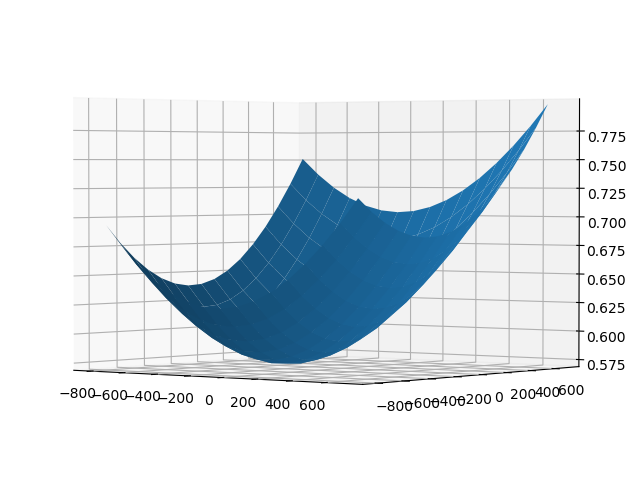

In [30]:
fig12 = plt.figure()
ax = Axes3D(fig12)
ax.plot_surface(X, Y, T[0])

Аналогично, **нет спецального метода для отрисовки сейсмограмм** - приходится сочинять что-то вроде этого:

In [ ]:
%%time
A = np.ones(shape=(1000,2000))
B = np.array(A)

In [ ]:
%%time
B = np.empty(A.ravel().shape)
for i, a in enumerate(A.ravel()):
    a += 1
B = B.reshape(A.shape)

In [ ]:
%%time
for i, t_i in enumerate(A):
    for j, t_ij in enumerate(t_i):
        t_ij += 1

In [ ]:
plt.figure()
plt.imshow(Tt)
plt.show()

In [ ]:
fig2 = plt.figure()

plt.title("Сейсмограмма (Z-компонента)")
plt.gca().invert_yaxis()
m = len(survey.rays[:16])
plt.yticks(np.arange(0, m, 1), np.round(rec_loc_x),
           fontsize = - 5 / 16 * m + 11 + 21 * 5 / 16)

for i in range(m):

    plt.fill_between(record_time, seismogram_z[i, :] / np.max(abs(seismogram_x)) / 1.5 + i,
                     np.ones(record_time.shape) * i,
                     linewidth = 0.3, color = 'b', alpha = 0.5)


plt.ylabel("Координаты вдоль профиля, м")
plt.xlabel("Время, с")

plt.show()

Питон выдаёт предупреждение о потере мнимой части сейсмограмм - и это тоже проблема, с которой пока что надо мириться.

# Cubic interp

In [ ]:
from src.tprt import bicubic_interpolation

In [ ]:
_y_set, _x_set = np.meshgrid(*[np.linspace(-1,1,10)]*2)
y_set, x_set = [np.linspace(-1,1,10)]*2
z_set = _x_set.copy() * 0

In [ ]:
a = bicubic_interpolation.two_dim_polynomial(x_set, y_set, z_set)

In [ ]:
a.shape

In [ ]:
x = np.linspace(-1,1, 10)
a_0 = x[1:-1] - x[:-2]
a_1 = x[2:] - x[:-2]
a_2 = x[1:-1] - x[:-2]
a_1.shape
# np.ones(3) - np.ones(3)

In [ ]:
def second_derivatives(x_set, z_set):
    """

    :param x_set: strictly ascending 1D-numerical array
    :param z_set: 1D-numerical array of corresponding values z = z(x)
    :return: 1D-numerical array of second derivatives z'' = z''(x) at points from x_set
    """

    # Returns array of second derivatives of z in x = x_set[i].

    # Here a system of linear equations is solved:
    # A m = B
    # Matrix A is three-diagonal. Som there is no need to keep it all.

    a = np.zeros((3, z_set.shape[0] - 2))  # here we shall write all three non-zero diagonals of the system's matrix
    b = np.zeros(a.shape[1])  # right part of the system

    a[1, 0] = (x_set[2] - x_set[0]) / 3
    a[2, 0] = (x_set[2] - x_set[1]) / 6

    a[0, -1] = (x_set[-2] - x_set[-3]) / 6
    a[1, -1] = (x_set[-1] - x_set[-3]) / 3

    b[0] = (z_set[2] - z_set[1]) / (x_set[2] - x_set[1]) - (z_set[1] - z_set[0]) / (x_set[1] - x_set[0])

    b[-1] = (z_set[- 1] - z_set[- 2]) / (x_set[- 1] - x_set[- 2]) -\
            (z_set[- 2] - z_set[- 3]) / (x_set[- 2] - x_set[- 3])
    
    for i in np.arange(1, a.shape[1] - 1, 1):

        a[0, i] = (x_set[i + 1] - x_set[i]) / 6
        a[1, i] = (x_set[i + 2] - x_set[i]) / 3
        a[2, i] = (x_set[i + 1] - x_set[i]) / 6

        b[i] = (z_set[i + 2] - z_set[i + 1]) / (x_set[i + 2] - x_set[i + 1]) -\
               (z_set[i + 1] - z_set[i]) / (x_set[i + 1] - x_set[i])
    return a, b

In [ ]:
x = np.linspace(-1,1,20)
z = np.random.randn(20)

In [ ]:
a, b = second_derivatives(x, z)

In [ ]:
from scipy.linalg import solve_banded


def second_derivatives_ad(x_set, z_set):
    """

    :param x_set: strictly ascending 1D-numerical array
    :param z_set: 1D-numerical array of corresponding values z = z(x)
    :return: 1D-numerical array of second derivatives z'' = z''(x) at points from x_set
    """

    # Returns array of second derivatives of z in x = x_set[i].

    # Here a system of linear equations is solved:
    # A m = B
    # Matrix A is three-diagonal. Som there is no need to keep it all.
    n0, n1 = z_set.shape
    a = np.zeros((3, n1 - 2, n0))  # here we shall write all three non-zero diagonals of the system's matrix
    b = np.zeros((n1 - 2, n0))  # right part of the system

    a[1, 0] = (x_set[2] - x_set[0]) / 3
    a[2, 0] = (x_set[2] - x_set[1]) / 6

    a[0, -1] = (x_set[-2] - x_set[-3]) / 6
    a[1, -1] = (x_set[-1] - x_set[-3]) / 3

    b[0] = (z_set[2] - z_set[1]) / (x_set[2] - x_set[1]) - (z_set[1] - z_set[0]) / (x_set[1] - x_set[0])

    b[-1] = (z_set[- 1] - z_set[- 2]) / (x_set[- 1] - x_set[- 2]) -\
            (z_set[- 2] - z_set[- 3]) / (x_set[- 2] - x_set[- 3])
    
    a[0, 1:-1] = (x_set[2:-2] - x_set[1:-3]) / 6
    a[1, 1:-1] = (x_set[3:-1] - x_set[1:-3]) / 3
    a[2, 1:-1] = (x_set[2:-2] - x_set[1:-3]) / 6
    b[1:-1] = (z_set[3:-1] - z_set[2:-2]) /  (x_set[3:-1] - x_set[2:-2]) - \
                (z_set[2:-2] - z_set[1:-3]) / (x_set[2:-2] - x_set[1:-3])
    
#     sec_deriv = solve_banded((1, 1), a, b)  # here are second derivatives in points x[1]...x[- 2].
#     # So, let's append left and right edges which are supposed to be equal to zero:

#     sec_deriv = np.append(0, sec_deriv)
#     sec_deriv = np.append(sec_deriv, 0)

    return a, b


def one_dim_polynomial(x_set, z_set):
    """

    :param x_set: strictly ascending 1D-numerical array
    :param z_set: 1D-numerical array of corresponding values z = z(x)
    :return: array of polynomial coefficients of cubic spline interpolation of z(x) function
    """

    # Returns array of coefficients of the interpolation ploynomials for function z_set defined on grid x_set with
    # second derivatives at the edges given.

    one_dim_coefficients = np.zeros((x_set.shape[0] - 1, 4))  # first index represents x_i (nearest left neighbour of
    # current x) and the second indicates the power of x in the polynomial.
    m_i = second_derivatives_ad(x_set, z_set)
    
    _step_i = x_set[1:] - x_set[:-1]
    
    _aa = m_i[:-1] * x_set[1:] ** 3 / (_step_i * 6)
    _bb = m_i[1:] * x_set[:-1] ** 3 / (_step_i * 6)
    _cc = (z_set[:-1] - m_i[:-1] * _step_i ** 2 / 6) * x_set[1:] / _step_i
    _dd = (z_set[1:] - m_i[1:] * _step_i ** 2 / 6) * x_set[:-1] / _step_i
    
    one_dim_coefficients[:, 0] = _aa- _bb + _cc - _dd
                
    _aa = -m_i[:-1] * 3 * x_set[1:] ** 2 / (_step_i * 6)
    _bb = m_i[1:] * 3 * x_set[:-1] ** 2 / (_step_i * 6)
    _cc = (z_set[:-1] - m_i[:-1] * _step_i ** 2 / 6) / _step_i
    _dd = (z_set[1:] - m_i[1:] * _step_i ** 2 / 6) / _step_i
    
    one_dim_coefficients[:, 1] = _aa + _bb - _cc + _dd
    
    _aa = m_i[:-1] * 3 * x_set[1:] / (_step_i * 6)
    _bb = m_i[1:] * 3 * x_set[:-1]  / (_step_i * 6)
    
    one_dim_coefficients[:, 2] = _aa - _bb
    
    _aa = -m_i[:-1]  / (_step_i * 6)
    _bb = m_i[1:]  / (_step_i * 6)
    
    one_dim_coefficients[:, 3] = _aa + _bb
    
    return one_dim_coefficients

In [ ]:
a_list = []
b_list = []
x = np.linspace(-1,1,20)
z = np.random.randn(10,20)
for _z in z:
    _a, _b = second_derivatives(x, _z)
    a_list.append(_a)
    b_list.append(_b)

In [ ]:
x[None,...].repeat(10, axis=0)[0]

In [ ]:
np.ones((3,4)) +np.ones((1,4))

In [ ]:
a, b = second_derivatives_ad(x[..., None], z.T)

In [ ]:
a

In [ ]:
a1 = one_dim_polynomial(x, z)

In [ ]:
a0 =  bicubic_interpolation.one_dim_polynomial(x, z)

In [ ]:
a1 - a0